In [ ]:
!pip install spectral --quiet

In [ ]:
!pip install scipy matplotlib scikit-learn --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from spectral import open_image, imshow
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat

In [ ]:
# !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

In [ ]:
data = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
labels = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
print(data.shape, labels.shape)

(145, 145, 200) (145, 145)


In [ ]:
import torch
from torch.utils.data import Dataset

PATCH_SIZE = 25  # must be odd so patch has a center pixel
HALF_SIZE = PATCH_SIZE // 2

def pad_cube(data, pad_width):
  return np.pad(data, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='reflect')

def pad_labels(labels, pad_width):
  return np.pad(labels, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=0)

In [ ]:
class HyperSpectralDataset(Dataset):
  def __init__(self, data, labels, patch_size):
    self.data = pad_cube(data, patch_size // 2)
    self.labels = pad_labels(labels, patch_size // 2)
    self.patch_size = patch_size
    self.indices = [
      (i, j) for i in range(labels.shape[0]) for j in range(labels.shape[1])
      if labels[i, j] > 0
    ]

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    i, j = self.indices[idx]
    i += HALF_SIZE
    j += HALF_SIZE
    patch = self.data[i - HALF_SIZE:i + HALF_SIZE + 1,j - HALF_SIZE:j + HALF_SIZE + 1,:]
    patch = patch.astype(np.float32)
    label = self.labels[i, j] - 1  # shift class labels to start from 0

    return torch.tensor(patch).permute(2, 0, 1), torch.tensor(label)

In [ ]:
reshaped = data.reshape(-1, data.shape[2])
normalized_data = reshaped / reshaped.max(axis=0)  # min-max scale per band
normalized_data = normalized_data.reshape(data.shape)

In [ ]:
from torch.utils.data import random_split, DataLoader

full_dataset = HyperSpectralDataset(normalized_data, labels, PATCH_SIZE)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SpectraX3DCNN(nn.Module):
  def __init__(self, num_classes):
    super(SpectraX3DCNN, self).__init__()
    self.conv1 = nn.Conv3d(1, 8, kernel_size=(7, 3, 3), padding=(0, 1, 1))
    self.bn1 = nn.BatchNorm3d(8)
    self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), padding=1)
    self.bn2 = nn.BatchNorm3d(16)
    self.pool = nn.MaxPool3d((1, 2, 2))
    spectral_output_size = 194
    spatial_output_size = 6
    flattened_size = 16 * spectral_output_size * spatial_output_size * spatial_output_size
    self.fc1 = nn.Linear(flattened_size, 128)
    self.dropout = nn.Dropout(0.4)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = x.unsqueeze(1)  # (Batch, 1, Bands, H, W)
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    # print("Shape before flattening:", x.shape) # Keep this print for verification if needed
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    return self.fc2(x)

## Visuals

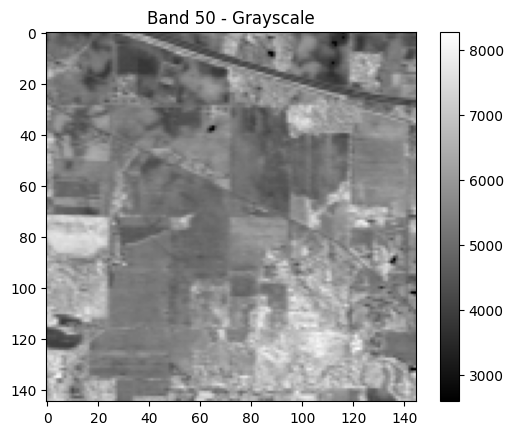

In [ ]:
plt.imshow(data[:, :, 50], cmap='gray')
plt.title("Band 50 - Grayscale")
plt.colorbar()
plt.show()

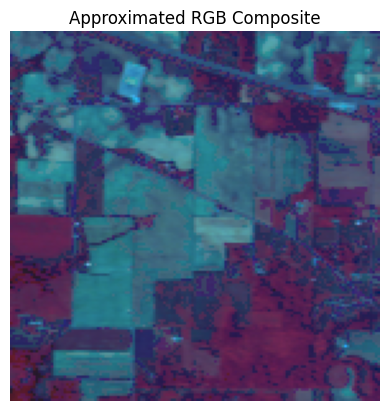

In [ ]:
# Approximate RGB using band indices
rgb_image = np.stack([
    data[:, :, 60],  # R (visible red)
    data[:, :, 30],  # G (green)
    data[:, :, 10]   # B (blue-ish)
], axis=-1)

# Normalize to 0–1
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.imshow(rgb_image)
plt.title("Approximated RGB Composite")
plt.axis('off')
plt.show()

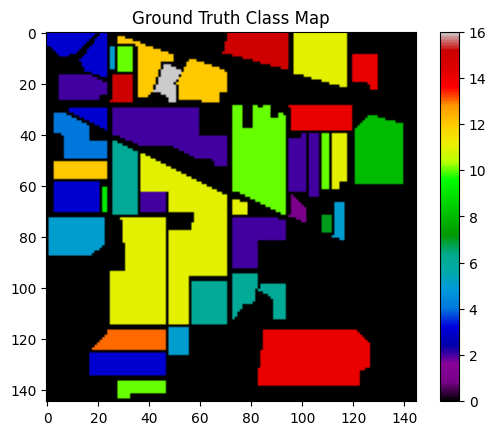

In [ ]:
plt.imshow(labels, cmap='nipy_spectral')
plt.title("Ground Truth Class Map")
plt.colorbar()
plt.show()

Patch shape (C, H, W): torch.Size([200, 25, 25])
Label: 2


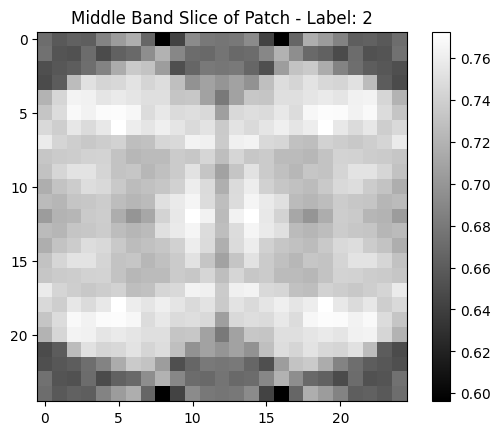

In [ ]:
sample_patch, sample_label = full_dataset[0]
print("Patch shape (C, H, W):", sample_patch.shape)
print("Label:", sample_label.item())

# Show central band slice of patch
plt.imshow(sample_patch[100].numpy(), cmap='gray')
plt.title(f"Middle Band Slice of Patch - Label: {sample_label.item()}")
plt.colorbar()
plt.show()

## Model 3d CNN

In [ ]:
from tqdm import tqdm

In [ ]:
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectraX3DCNN(num_classes=16).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 8
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  correct = 0

  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
  for inputs, labels in loop:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    correct += (outputs.argmax(1) == labels).sum().item()

    loop.set_postfix(loss=loss.item())

  acc = 100 * correct / len(train_loader.dataset)
  print(f"✅ Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f} - Accuracy: {acc:.2f}%")
  '''


'\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel = SpectraX3DCNN(num_classes=16).to(device)\n\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\ncriterion = nn.CrossEntropyLoss()\n\nEPOCHS = 8\nfor epoch in range(EPOCHS):\n  model.train()\n  total_loss = 0\n  correct = 0\n\n  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")\n  for inputs, labels in loop:\n    inputs, labels = inputs.to(device), labels.to(device)\n\n    optimizer.zero_grad()\n    outputs = model(inputs)\n    loss = criterion(outputs, labels)\n    loss.backward()\n    optimizer.step()\n\n    total_loss += loss.item()\n    correct += (outputs.argmax(1) == labels).sum().item()\n\n    loop.set_postfix(loss=loss.item())\n\n  acc = 100 * correct / len(train_loader.dataset)\n  print(f"✅ Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f} - Accuracy: {acc:.2f}%")\n  '

In [ ]:
#torch.save(model.state_dict(), "spectrax8_model.pth")

In [ ]:
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectraX3DCNN(num_classes=16).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 30

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  correct = 0

  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
  for inputs, labels in loop:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    correct += (outputs.argmax(1) == labels).sum().item()

    loop.set_postfix(loss=loss.item())

  acc = 100 * correct / len(train_loader.dataset)
  print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f} - Accuracy: {acc:.2f}%")
  '''

'\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel = SpectraX3DCNN(num_classes=16).to(device)\n\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\ncriterion = nn.CrossEntropyLoss()\n\nEPOCHS = 30\n\nfor epoch in range(EPOCHS):\n  model.train()\n  total_loss = 0\n  correct = 0\n\n  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")\n  for inputs, labels in loop:\n    inputs, labels = inputs.to(device), labels.to(device)\n\n    optimizer.zero_grad()\n    outputs = model(inputs)\n    loss = criterion(outputs, labels)\n    loss.backward()\n    optimizer.step()\n\n    total_loss += loss.item()\n    correct += (outputs.argmax(1) == labels).sum().item()\n\n    loop.set_postfix(loss=loss.item())\n\n  acc = 100 * correct / len(train_loader.dataset)\n  print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f} - Accuracy: {acc:.2f}%")\n  '

In [ ]:
#torch.save(model.state_dict(), "spectrax30_model.pth")

## Model custom 2

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SpectraXPlus(nn.Module):
  def __init__(self, num_classes):
    super(SpectraXPlus, self).__init__()

    # 3D Convolutional Layers (Spectral-Spatial)
    self.conv3d_1 = nn.Conv3d(1, 8, kernel_size=(7, 3, 3), padding=(0,1,1))
    self.bn3d_1 = nn.BatchNorm3d(8)

    self.conv3d_2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), padding=1)
    self.bn3d_2 = nn.BatchNorm3d(16)

    # Reduce to 2D by flattening spectral axis
    self.conv2d_1 = nn.Conv2d(16 * 194, 128, kernel_size=3, padding=1)
    self.bn2d_1 = nn.BatchNorm2d(128)

    self.pool = nn.AdaptiveAvgPool2d(1)
    self.dropout = nn.Dropout(0.5)

    self.fc = nn.Linear(128, num_classes)


  def forward(self, x):
    x = x.unsqueeze(1)
    # Input: [B, 1, C, H, W]
    x = F.relu(self.bn3d_1(self.conv3d_1(x)))
    x = F.relu(self.bn3d_2(self.conv3d_2(x)))

    # Collapse spectral dimension into channels
    B, C, D, H, W = x.shape # B=Batch, C=16, D=194, H=25, W=25
    x = x.view(B, C * D, H, W) # New shape: [B, 16*194, 25, 25]
    x = F.relu(self.bn2d_1(self.conv2d_1(x))) # Output shape: [B, 128, 25, 25]
    x = self.pool(x)
    x = x.squeeze(-1).squeeze(-1)
    x = self.dropout(x)
    return self.fc(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectraXPlus(num_classes=16).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 30
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  correct = 0

  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
  for inputs, labels in loop:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      correct += (outputs.argmax(1) == labels).sum().item()

      loop.set_postfix(loss=loss.item())

  acc = 100 * correct / len(train_loader.dataset)
  print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f} - Accuracy: {acc:.2f}%")

Epoch 1/30: 100%|██████████| 129/129 [01:06<00:00,  1.93it/s, loss=0.831]


Epoch 1/30 - Loss: 170.3056 - Accuracy: 61.73%


Epoch 2/30: 100%|██████████| 129/129 [01:08<00:00,  1.90it/s, loss=0.935]


Epoch 2/30 - Loss: 90.9584 - Accuracy: 80.60%


Epoch 3/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.187]


Epoch 3/30 - Loss: 67.0900 - Accuracy: 85.86%


Epoch 4/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.294]


Epoch 4/30 - Loss: 51.9637 - Accuracy: 88.21%


Epoch 5/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.345]


Epoch 5/30 - Loss: 44.5372 - Accuracy: 88.88%


Epoch 6/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.701]


Epoch 6/30 - Loss: 39.1345 - Accuracy: 90.60%


Epoch 7/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.238]


Epoch 7/30 - Loss: 35.9026 - Accuracy: 91.28%


Epoch 8/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=1.19]


Epoch 8/30 - Loss: 32.3082 - Accuracy: 92.08%


Epoch 9/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.342]


Epoch 9/30 - Loss: 32.1988 - Accuracy: 92.23%


Epoch 10/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.441]


Epoch 10/30 - Loss: 29.4767 - Accuracy: 92.63%


Epoch 11/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.202]


Epoch 11/30 - Loss: 30.1915 - Accuracy: 91.90%


Epoch 12/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.939]


Epoch 12/30 - Loss: 24.1102 - Accuracy: 93.99%


Epoch 13/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=1.04]


Epoch 13/30 - Loss: 22.9946 - Accuracy: 94.68%


Epoch 14/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.794]


Epoch 14/30 - Loss: 25.7244 - Accuracy: 93.58%


Epoch 15/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.828]


Epoch 15/30 - Loss: 25.7250 - Accuracy: 93.43%


Epoch 16/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.391]


Epoch 16/30 - Loss: 21.2453 - Accuracy: 94.84%


Epoch 17/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.277]


Epoch 17/30 - Loss: 18.1016 - Accuracy: 95.46%


Epoch 18/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.101]


Epoch 18/30 - Loss: 17.4470 - Accuracy: 95.29%


Epoch 19/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.363]


Epoch 19/30 - Loss: 16.9810 - Accuracy: 95.46%


Epoch 20/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.124]


Epoch 20/30 - Loss: 15.4954 - Accuracy: 96.04%


Epoch 21/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.305]


Epoch 21/30 - Loss: 14.4675 - Accuracy: 96.07%


Epoch 22/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.305]


Epoch 22/30 - Loss: 14.2728 - Accuracy: 96.54%


Epoch 23/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.104]


Epoch 23/30 - Loss: 14.3980 - Accuracy: 96.30%


Epoch 24/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.139]


Epoch 24/30 - Loss: 14.8741 - Accuracy: 96.08%


Epoch 25/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.229]


Epoch 25/30 - Loss: 12.4481 - Accuracy: 96.85%


Epoch 26/30: 100%|██████████| 129/129 [01:08<00:00,  1.88it/s, loss=0.0119]


Epoch 26/30 - Loss: 11.3080 - Accuracy: 97.09%


Epoch 27/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.0111]


Epoch 27/30 - Loss: 10.7309 - Accuracy: 97.35%


Epoch 28/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.231]


Epoch 28/30 - Loss: 10.2875 - Accuracy: 97.60%


Epoch 29/30: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=0.354]


Epoch 29/30 - Loss: 14.6547 - Accuracy: 96.44%


Epoch 30/30: 100%|██████████| 129/129 [01:07<00:00,  1.90it/s, loss=0.492]

Epoch 30/30 - Loss: 11.6210 - Accuracy: 97.24%


In [ ]:
torch.save(model.state_dict(), "SpectraXPlus_best1.pth")

In [ ]:
class_names = {
0: "Background",
1: "Alfalfa",
2: "Corn-notill",
3: "Corn-mintill",
4: "Corn",
5: "Grass-pasture",
6: "Grass-trees",
7: "Grass-pasture-mowed",
8: "Hay-windrowed",
9: "Oats",
10: "Soybean-notill",
11: "Soybean-mintill",
12: "Soybean-clean",
13: "Wheat",
14: "Woods",
15: "Buildings-Grass-Trees-Drives",
16: "Stone-Steel-Towers"
}

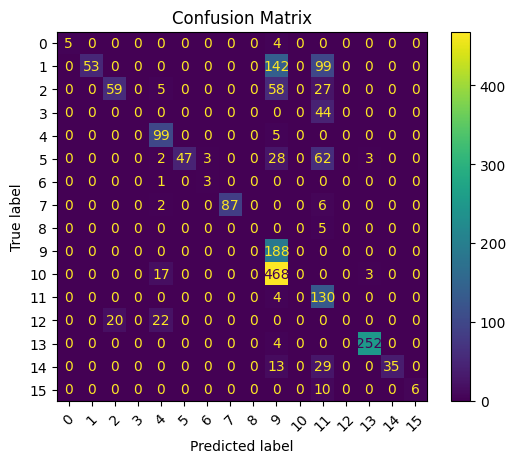

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      pred = model(x).argmax(dim=1)
      all_preds.extend(pred.cpu().numpy())
      all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.eval()
correct = 0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    preds = outputs.argmax(dim=1)
    correct += (preds == labels).sum().item()

val_acc = 100 * correct / len(test_loader.dataset)
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 47.02%


In [ ]:
def create_full_prediction_map(model, data, patch_size=25, device='cuda'):
    """Create full scene classification map using sliding window"""
    h, w, bands = data.shape
    pad = patch_size // 2

    # Initialize prediction map
    prediction_map = np.zeros((h, w), dtype=np.int32)

    # Pad the data
    padded_data = np.pad(data, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

    model.eval()
    print("Generating full scene prediction map...")

    with torch.no_grad():
        # Process in batches to avoid memory issues
        batch_size = 64
        patches = []
        positions = []

        # Collect all patches
        for i in range(h):
            for j in range(w):
                # Extract patch
                patch = padded_data[i:i+patch_size, j:j+patch_size, :]
                patches.append(patch)
                positions.append((i, j))

                # Process batch
                if len(patches) == batch_size or (i == h-1 and j == w-1):
                    # Convert to tensor
                    batch_patches = np.array(patches)
                    batch_tensor = torch.FloatTensor(batch_patches).to(device)

                    # Reshape: [B, H, W, Bands] -> [B, Bands, H, W]
                    batch_tensor = batch_tensor.permute(0, 3, 1, 2)

                    # Get predictions
                    outputs = model(batch_tensor)
                    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

                    # Assign predictions to map
                    for k, (row, col) in enumerate(positions):
                        prediction_map[row, col] = predictions[k] + 1  # +1 to match ground truth indexing

                    # Clear batch
                    patches = []
                    positions = []

    return prediction_map

def create_full_prediction_map_fast(model, data, ground_truth_labels_np, patch_size=25, device='cuda'):
    """Faster version - only predict on labeled pixels"""
    h, w, bands = data.shape
    pad = patch_size // 2

    # Use the provided ground truth labels (NumPy array)
    labeled_positions = np.where(ground_truth_labels_np != 0)

    # Check if np.where returned a tuple of two arrays and if the arrays are not empty
    if len(labeled_positions) < 2 or labeled_positions[0].size == 0:
        print("No labeled pixels found or unexpected output from np.where. Returning empty prediction map.")
        return np.zeros((h, w), dtype=np.int32)

    total_pixels = len(labeled_positions[0])

    # Initialize prediction map
    prediction_map = np.zeros((h, w), dtype=np.int32)

    # Pad the data
    padded_data = np.pad(data, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

    model.eval()
    print(f"Predicting {total_pixels} labeled pixels...")

    with torch.no_grad():
        batch_size = 64

        for idx in tqdm(range(0, total_pixels, batch_size)):
            batch_end = min(idx + batch_size, total_pixels)
            batch_patches = []
            batch_positions = []

            # Extract batch of patches
            for i in range(idx, batch_end):
                row, col = labeled_positions[0][i], labeled_positions[1][i]
                patch = padded_data[row:row+patch_size, col:col+patch_size, :]
                batch_patches.append(patch)
                batch_positions.append((row, col))

            # Convert to tensor
            batch_patches = np.array(batch_patches)
            batch_tensor = torch.FloatTensor(batch_patches).to(device)

            # Reshape: [B, H, W, Bands] -> [B, Bands, H, W]
            batch_tensor = batch_tensor.permute(0, 3, 1, 2)

            # Get predictions
            outputs = model(batch_tensor)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()

            # Assign predictions to map
            for k, (row, col) in enumerate(batch_positions):
                prediction_map[row, col] = predictions[k] + 1  # +1 to match ground truth indexing

            # Clear batch
            patches = []
            positions = []

    return prediction_map

In [ ]:
# Load the original ground truth labels as a NumPy array
original_labels_np = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# Assuming 'data' and 'model' are available from previous cells
prediction_map = create_full_prediction_map_fast(model, data, original_labels_np, device=device)

Predicting 10249 labeled pixels...


100%|██████████| 161/161 [00:23<00:00,  6.87it/s]


In [ ]:
from matplotlib.colors import ListedColormap

def visualize_results(ground_truth, prediction_map, save_path=None):
    """Visualize ground truth vs predictions"""
    # Create custom colormap (matching typical hyperspectral visualization)
    colors = ['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan',
              'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy',
              'maroon', 'lime', 'teal', 'silver', 'gold']

    # Ensure we have enough colors
    while len(colors) < 17:
        colors.append('gray')

    cmap = ListedColormap(colors[:17])

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ground Truth
    im1 = axes[0].imshow(ground_truth, cmap=cmap, vmin=0, vmax=16)
    axes[0].set_title('Ground Truth', fontsize=14)
    axes[0].set_xlabel('Pixel')
    axes[0].set_ylabel('Pixel')

    # Predictions
    im2 = axes[1].imshow(prediction_map, cmap=cmap, vmin=0, vmax=16)
    axes[1].set_title('Model Predictions', fontsize=14)
    axes[1].set_xlabel('Pixel')
    axes[1].set_ylabel('Pixel')

    # Difference map (errors in red)
    difference = np.zeros_like(ground_truth)
    mask = ground_truth != 0  # Only labeled pixels
    difference[mask] = (ground_truth[mask] != prediction_map[mask]).astype(int)

    im3 = axes[2].imshow(difference, cmap='Reds', vmin=0, vmax=1)
    axes[2].set_title('Errors (Red = Wrong)', fontsize=14)
    axes[2].set_xlabel('Pixel')
    axes[2].set_ylabel('Pixel')

    # Add colorbars
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

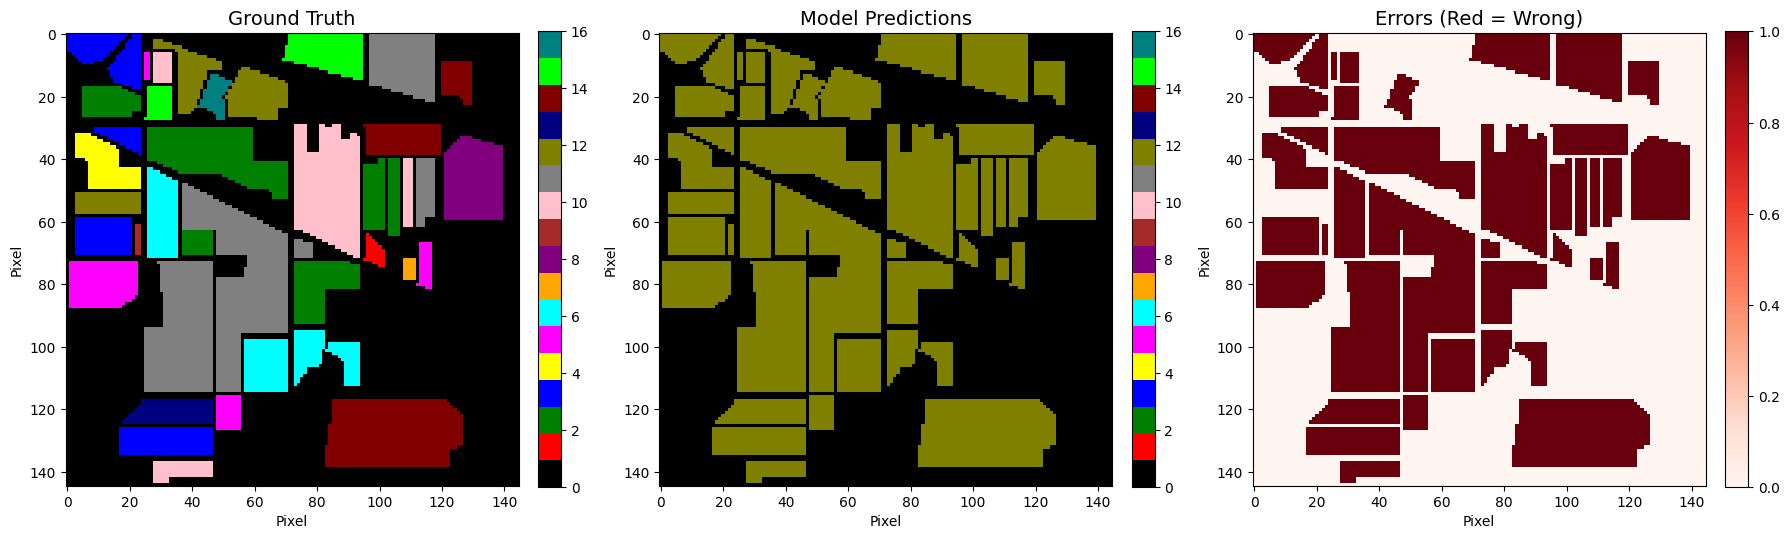

In [ ]:
visualize_results(original_labels_np, prediction_map, save_path='classification_results.png')